[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mjwen/chee6397/blob/main/lab/lab5-intro_pytorch.ipynb)

# Lab 5: Intro to automatic differentiation and PyTorch  

This notebook is intended to introduce:
- the basic ideas of automatic differentiation and how to use it in PyTorch;
- the basic ideas of PyTorch and how to use it to train a simple MLP.

## Installation

Follow the instructions on the [PyTorch website](https://pytorch.org/get-started/locally/) to install PyTorch. 
We will only use the CPU version in this lab, so you can ignore the CUDA related options.

## PyTorch basics

### PyTorch can be used as a replacement of Numpy

In [1]:
import numpy as np
import torch

In [34]:
M1 = np.array([[1., 2., 3.], [4., 5., 6.]])
M1

array([[1., 2., 3.],
       [4., 5., 6.]])

In [3]:
M1.shape

(2, 3)

In [7]:
help(torch)

c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Help on package torch:

NAME
    torch

DESCRIPTION
    The torch package contains data structures for multi-dimensional
    tensors and defines mathematical operations over these tensors.
    Additionally, it provides many utilities for efficient serialization of
    Tensors and arbitrary types, and other useful utilities.
    
    It has a CUDA counterpart, that enables you to run your tensor computations
    on an NVIDIA GPU with compute capability >= 3.0.

PACKAGE CONTENTS
    _C
    _VF
    __config__
    __future__
    _appdirs
    _awaits (package)
    _classes
    _compile
    _custom_op (package)
    _custom_ops
    _decomp (package)
    _deploy
    _dispatch (package)
    _dynamo (package)
    _export (package)
    _functorch (package)
    _guards
    _higher_order_ops (package)
    _inductor (package)
    _jit_internal
    _lazy (package)
    _linalg_utils
    _lobpcg
    _logging (package)
    _lowrank
    _meta_registrations
    _namedtensor_internals
    _numpy (package)


In [8]:
v1 = np.array([1., 2., 3.]).reshape(3, 1)

v1

array([[1.],
       [2.],
       [3.]])

In [9]:
M1@v1

array([[14.],
       [32.]])

In [11]:
M2 = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
M2

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [12]:
M2.shape


torch.Size([2, 3])

In [15]:
M3 = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float)
M3

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [18]:
v2 = torch.tensor([1., 2., 3.]).reshape(3, 1)
v2

tensor([[1.],
        [2.],
        [3.]])

* Matrix multiplication

In [20]:
M2@v2

tensor([[14.],
        [32.]])

### Converting between numpy and torch

In [37]:
M1

array([[1., 2., 3.],
       [4., 5., 6.]])

In [39]:
M4 = torch.from_numpy(M1)
M4

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)

* M1 and M4 are `deep copy`

In [40]:
M1[0,0] = 10
M1 

array([[10.,  2.,  3.],
       [ 4.,  5.,  6.]])

In [41]:
M4

tensor([[10.,  2.,  3.],
        [ 4.,  5.,  6.]], dtype=torch.float64)

In [25]:
type(M2)

torch.Tensor

In [26]:
M2.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

## Automatic differentiation with PyTorch

We will use the following simple example to illustrate the basic ideas of automatic differentiation.

$L = \sigma (wx + b) $

* Example:
    * $L = (y - wx)^2$

    * $\frac{\partial L}{\partial w} = 2(y - wx)(-x)$

    * $\frac{\partial L}{\partial x} = 2(y - wx)(-w)$

In [52]:
x = torch.tensor([1., 2., 3.])
w = torch.tensor([4., 5., 6.], requires_grad=True)
y = torch.zeros(3)

In [53]:
diff =  y - w*x
diff

tensor([ -4., -10., -18.], grad_fn=<SubBackward0>)

In [54]:
square = diff**2
square

tensor([ 16., 100., 324.], grad_fn=<PowBackward0>)

In [55]:
L = torch.sum(square)
L

tensor(440., grad_fn=<SumBackward0>)

Get the gradient of L with respect to w

In [56]:
dw = torch.autograd.grad(L, w)
# w is initialized with requires_grad = True
dw

(tensor([  8.,  40., 108.]),)

Cannot get grad of L with respect to x (because x does not require grad)

In [57]:
# dx = torch.autograd.grad(L, x)

### Alternative way to get grad instead of calling autograd.grad

Note:
- this is the recommended way to get the gradient.
- cannot backpropagate a second time. So comment out the above dw cells to run the below.

In [59]:
x = torch.tensor([1., 2., 3.])
w = torch.tensor([4., 5., 6.], requires_grad=True)
y = torch.zeros(3)
diff =  y - w*x
square = diff**2
L = torch.sum(square)

In [62]:
print(x.grad)
print(w.grad)

None
None


In [63]:
L.backward()

In [66]:
print(w.grad)

tensor([  8.,  40., 108.])


In [65]:
print(x.grad)

None


### You can even get higher order derivatives 

In [67]:
def get_loss(w):
    x = torch.tensor([1., 2., 3.])
    y = torch.zeros(3)

    L = torch.sum((y - w*x)**2)

    return L

Get the Hessian 

In [71]:
from torch.autograd.functional import hessian

w = torch.tensor([4., 5., 6.], requires_grad=True)

hessian(get_loss, w)

tensor([[ 2.,  0.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0., 18.]])

## MLP with PyTorch 

In [72]:
import torch.nn as nn

class MyTwoLayerMLP(nn.Module):

    def __init__(self, num_input_nodes, num_hidden_nodes, num_out_nodes):
        # call the parent class's __init__ method to initialize inherited attribute
        super().__init__()

        self.num_input_nodes = num_input_nodes
        self.num_hidden_nodes = num_hidden_nodes
        self.num_out_nodes = num_out_nodes

        # input parameter: number of input nodes and output nodes (hidden nodes are output nodes in intermediate layers)
        self.layer1 = nn.Linear(num_input_nodes, num_hidden_nodes)
        self.layer2 = nn.Linear(num_hidden_nodes, num_out_nodes)



    def forward(self, X):

        h = self.layer1(X)
        y1 = torch.relu(h)
        h2 = self.layer2(y1)

        return y

### Let's create some data to test our model

In [23]:
torch.manual_seed(0)  # random seed

def generate_data(N, num_in=3):
    """Generate some random data with num_in=3 features x1, x2, x3.
    The target is y = x1^2 + x2^2 + x3^2.

    Args:
        N: number of samples
        num_in: number of input features
    """
    X = torch.randn(N, num_in)
    y = torch.square(X).sum(dim=1).reshape(N, 1)

    return X, y


In [24]:

X, y = generate_data(N=100, num_in=3)

In [25]:
X.shape

torch.Size([100, 3])

In [26]:
y.shape

torch.Size([100, 1])

### Create a model with 10 hidden nodes

In [27]:
num_in = 3
num_hidden = 10
num_out  = 1

model = MyTwoLayerMLP(num_in, num_hidden, num_out)

Let's check that the model works 

In [28]:
y_pred = model(X)

y_pred.shape


torch.Size([100, 1])

### Train the model 

In [29]:
def train_one_step(model, optimizer, X, y):
    """Performs one step of gradient descent on the given model.

    Args:
        model: the model to train
        optimizer: the optimizer to use
        X: the input data
        y: the target data
    """
    y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [30]:
### Using SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [31]:
num_steps = 30

losses = []
for s in range(num_steps):
    for X_i, y_i in zip(X, y):
        l = train_one_step(model, optimizer, X_i, y_i)
        losses.append(l.item())

Text(0, 0.5, 'loss')

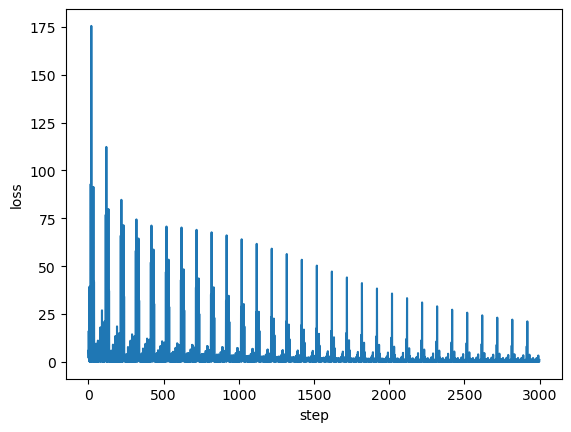

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(losses)

ax.set_xlabel('step')
ax.set_ylabel('loss')

# Note, the loss is the training loss for each individual sample